# **Libraries**

In [20]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import more_itertools

# **Reading the data**

In [10]:
def read_order_types_for_df(file_content):
    dtype = 'uint8'
    points = file_content.reshape(-1, 2)
    df = pd.DataFrame(points, columns=['x', 'y'], dtype=dtype)
    return df

def read_order_types(file_content):
    dtype = 'uint8'
    points = file_content.reshape(-1, 2)
    return points

In [11]:
file_url = "http://www.ist.tugraz.at/staff/aichholzer/research/rp/triangulations/ordertypes/data/otypes06.b08"

# downloading set points
response = requests.get(file_url)
file_content = response.content

# Use BytesIO to create a file-like object from the bytes content
file_like_object = BytesIO(file_content)

In [15]:
# Reading content into data frame
file_content_array = np.frombuffer(file_like_object.getvalue(), dtype=np.uint8)
df = read_order_types_for_df(file_content_array)
df.head()

,x,y
0,230,192
1,248,78
2,148,36
3,54,72
4,30,160


In [16]:
# Reading content into matrix
data = read_order_types(file_content_array)
data = list(data)
data = [list(x) for x in data]
data[:5]

[[230, 192], [248, 78], [148, 36], [54, 72], [30, 160]]

# **Point set**

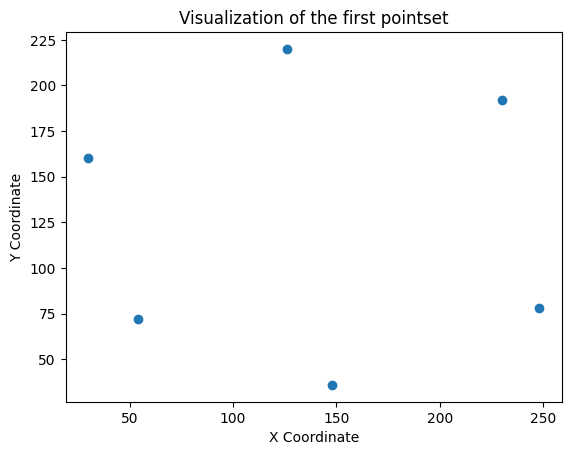

In [18]:
# Visualize the first pointset
plt.scatter(df['x'][:6], df['y'][:6])
plt.title('Visualization of the first pointset')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

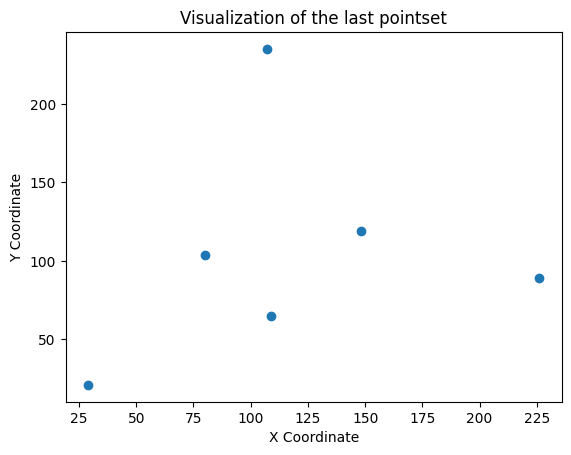

In [19]:
# Visualize the last pointset
plt.scatter(df['x'][90:96], df['y'][90:96])
plt.title('Visualization of the last pointset')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

# **Algorithm**

We firstly generated all 42355950 partitions of a set of 15 elements. They are stored in the variable ```colorings``` since we consider are partitions to be colorings of edges.

In [ ]:
l = [i for i in range(15)]

colorings = []
i=1
j=1
for part in more_itertools.set_partitions(l, 4):  #function in S,k to generate all partitions of S of size k
  if j%1000000==1:print('i have generated {} partitions'.format(j))
  j+=1
  colorings.append(part)

i have generated 1 partitions
i have generated 1000001 partitions
i have generated 2000001 partitions
i have generated 3000001 partitions
i have generated 4000001 partitions
i have generated 5000001 partitions
i have generated 6000001 partitions
i have generated 7000001 partitions
i have generated 8000001 partitions
i have generated 9000001 partitions
i have generated 10000001 partitions
i have generated 11000001 partitions
i have generated 12000001 partitions
i have generated 13000001 partitions
i have generated 14000001 partitions
i have generated 15000001 partitions
i have generated 16000001 partitions
i have generated 17000001 partitions
i have generated 18000001 partitions
i have generated 19000001 partitions
i have generated 20000001 partitions
i have generated 21000001 partitions
i have generated 22000001 partitions
i have generated 23000001 partitions
i have generated 24000001 partitions
i have generated 25000001 partitions
i have generated 26000001 partitions
i have generated 

We define a couple of helper functions, to help us generate all edges of a complete graph given its vertices, and to transfrom a partition into forests describing the generated edges.

In [ ]:
def generate_edges(vertices):
  edges = []
  for u in range(len(vertices)):
    for v in range(u+1,len(vertices)):
      if u != v: edges.append((vertices[u],vertices[v]))
  return edges

def from_part_to_forests(part):
  forests = []
  for p in range(len(part)):
    forests.append([])
    for e in part[p]:
      forests[p].append(edges[e])
  return forests

def from_part_to_forests_data(part,edges_data):
  forests_data = []
  for p in range(len(part)):
    forests_data.append([])
    for e in (part[p]):
      forests_data[p].append(edges_data[e])
  return forests_data

We define the function ```check_star_forest``` to check whether a part of a partition is a star-forest. Afterwards, we use it to find out which partitions are star-forest decompostions. We end up with 120 partitions, narrowing the options greatly.

In [ ]:
import networkx as nx
import itertools

def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first, itertools.chain([first], iterable)

def check_star_forest(forest,vertices,n):
  graph_forest = nx.Graph(forest)
  count = [0 for i in range(n)]
  big_degree = []
  for edge in forest:
    u = vertices.index(edge[0])
    v = vertices.index(edge[1])
    count[u] += 1
    count[v] += 1
    if count[u] >= 2:
      for w in big_degree:
        if not peek(nx.all_simple_paths(graph_forest, source=vertices[u], target=vertices[w])) is None:
          return False
      big_degree.append(vertices[u])
    if count[v] >= 2:
      for w in big_degree:
        if not peek(nx.all_simple_paths(graph_forest, source=vertices[v], target=vertices[w])) is None:
          return False
      big_degree.append(vertices[v])
  return True

def check_sf_partition(partition, n):
  fs = from_part_to_forests(partition)
  for f in fs:
    if not check_star_forest(f,vertices,n): return False
  return True



In [ ]:
vertices = [i for i in range(6)]
edges = generate_edges(vertices)

print(len(colorings))

k=0
valid_sfs = []
for c in colorings:
  if k%10000000 == 0: print('checked {} partitions'.format(k))
  k+=1
  if check_sf_partition(c,6): valid_sfs.append(c)

print(len(valid_sfs))

42355950
checked 0 partitions
checked 10000000 partitions
checked 20000000 partitions
checked 30000000 partitions
checked 40000000 partitions
120


Next, we want to check if these decompostions are planar for each point set. We thus define the function ```check_forests_planar```.

In [ ]:
def ccw(A,B,C):
  #(C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)
  return (int(C[1])-int(A[1])) * (int(B[0])-int(A[0])) > (int(B[1])-int(A[1])) * (int(C[0])-int(A[0]))

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
  return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def check_planar(forest):
  for a in forest:
    for b in forest:
      if a != b and intersect(a[0],a[1],b[0],b[1]): return False
  return True

def check_forests_planar(fore):
  for fo in fore:
    if not check_planar(fo): return False
  return True

In [ ]:
def check_pointset(m,n):
  vertices_data = data[m:m+n]
  edges_data = generate_edges(vertices_data)
  j = 0
  res = []
  for check in valid_sfs:
    if j%30 == 0: print('checked {} partitions'.format(j))
    j+=1
    forests_data = from_part_to_forests_data(check,edges_data)
    if check_forests_planar(forests_data): res.append(check)
  return (vertices_data,res)

To help us visualize the results, we define a plotting function.

In [ ]:
def plot_edges(components, vertices_data, save_path=None):

    edges_data = generate_edges(vertices_data)
    edge_styles = ['-', '--', '-.', ':']
    edge_colors = ['b', 'g', 'r', 'm', 'c', 'k']
    vertex_marker = 'ko'

    fig, ax = plt.subplots(figsize=(8, 8))

    for i, component in enumerate(components):
        for j, edge_idx in enumerate(component):
            edge = edges_data[edge_idx]
            x, y = zip(edge[0], edge[1])
            style = edge_styles[i % len(edge_styles)]
            color = edge_colors[i % len(edge_colors)]
            ax.plot(x, y, linestyle=style, linewidth=3, color=color, marker='o')

        for edge_idx in component:
            for vertex in edges_data[edge_idx]:
                ax.plot(vertex[0], vertex[1], vertex_marker)

    ax.set_axis_off()

    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()

We now check whether any pointset admits a planar star-forest decompostion, and visualize an example for each of the ones that do.

In [ ]:
check_pointset(90,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[29, 21], [107, 235], [80, 104], [148, 119], [109, 65], [226, 89]],
 [[[0, 6, 10, 11], [1, 4, 7, 12], [3, 5, 13], [2, 8, 9, 14]],
  [[0, 3, 9, 11], [2, 5, 8, 12], [4, 7, 10, 13], [1, 6, 14]]])

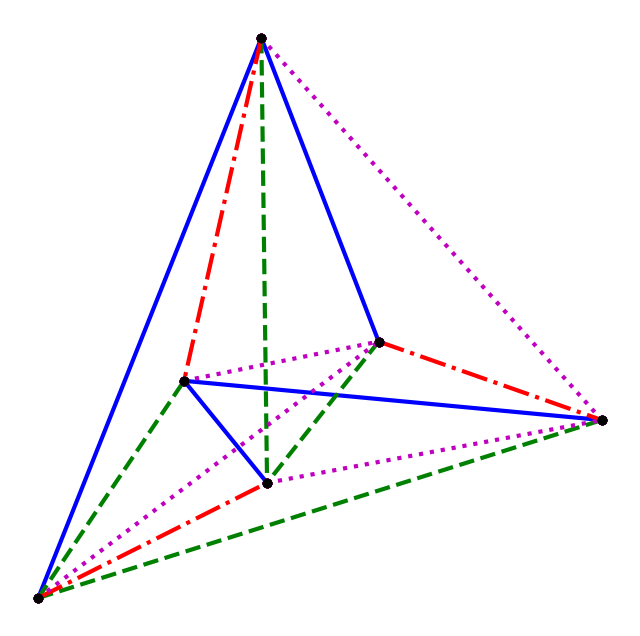

In [ ]:
components = [[0, 6, 10, 11], [1, 4, 7, 12], [3, 5, 13], [2, 8, 9, 14]]
plot_edges(components, data[90: 96], "output1.svg")

In [ ]:
check_pointset(84,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[5, 240], [253, 136], [194, 131], [63, 182], [101, 83], [65, 15]],
 [[[3, 4, 5, 6], [0, 11, 12], [2, 7, 10, 13], [1, 8, 9, 14]],
  [[2, 4, 5, 7], [0, 11, 12], [1, 8, 10, 13], [3, 6, 9, 14]],
  [[3, 8, 9], [2, 4, 7, 10], [1, 5, 12, 13], [0, 6, 11, 14]],
  [[4, 7, 9], [3, 6, 8, 10], [1, 5, 12, 13], [0, 2, 11, 14]],
  [[3, 8, 9], [2, 6, 10, 11], [1, 4, 7, 12], [0, 5, 13, 14]],
  [[4, 7, 9], [2, 6, 10, 11], [3, 5, 8, 12], [0, 1, 13, 14]],
  [[2, 7, 8, 9], [3, 6, 11], [0, 4, 10, 12], [1, 5, 13, 14]],
  [[3, 8, 9], [2, 6, 10, 11], [4, 5, 7, 13], [0, 1, 12, 14]],
  [[3, 4, 5, 9], [0, 8, 10, 12], [1, 7, 13], [2, 6, 11, 14]],
  [[3, 4, 5, 9], [1, 8, 12], [2, 7, 10, 13], [0, 6, 11, 14]],
  [[2, 4, 7, 10], [3, 6, 11], [0, 5, 12, 13], [1, 8, 9, 14]],
  [[4, 8, 9, 10], [3, 6, 11], [2, 5, 7, 13], [0, 1, 12, 14]],
  [[0, 4, 9, 10], [2, 8, 11, 12], [1, 7, 13], [3, 5, 6, 14]],
  [[0, 4, 9, 10], [3, 5, 8, 12], [1, 7, 13], [2, 6, 11, 14]],
  [[0, 2, 10, 11], [3, 5, 8, 12], [1, 7, 13], [4, 6, 9, 14]],
 

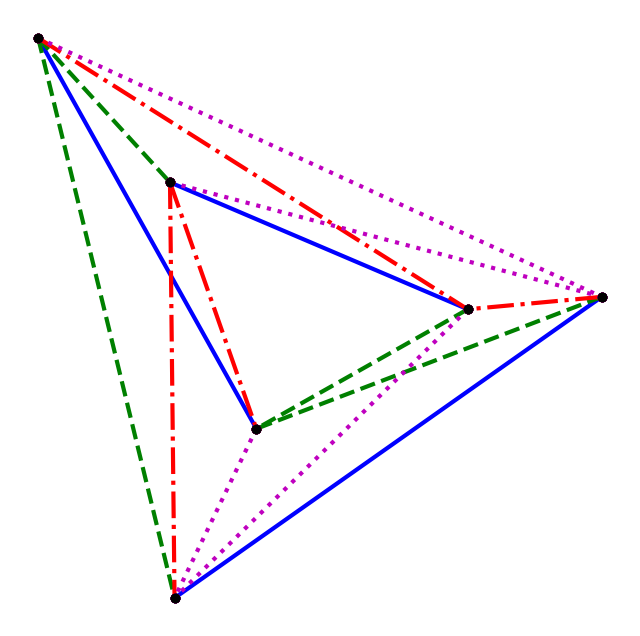

In [ ]:
components = [[3, 8, 9], [2, 4, 7, 10], [1, 5, 12, 13], [0, 6, 11, 14]]
plot_edges(components, data[84: 90], "output2.svg")

In [ ]:
check_pointset(78,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[21, 247], [235, 103], [133, 81], [86, 122], [50, 93], [20, 9]],
 [[[3, 8, 9], [2, 4, 7, 10], [1, 5, 12, 13], [0, 6, 11, 14]],
  [[3, 4, 6, 9], [2, 7, 11], [0, 8, 10, 12], [1, 5, 13, 14]],
  [[4, 8, 9, 10], [2, 7, 11], [0, 1, 12, 13], [3, 5, 6, 14]],
  [[3, 6, 8, 10], [2, 7, 11], [0, 1, 12, 13], [4, 5, 9, 14]],
  [[2, 8, 10], [4, 6, 7, 11], [0, 1, 12, 13], [3, 5, 9, 14]],
  [[2, 4, 7, 10], [3, 6, 11], [0, 5, 12, 13], [1, 8, 9, 14]]])

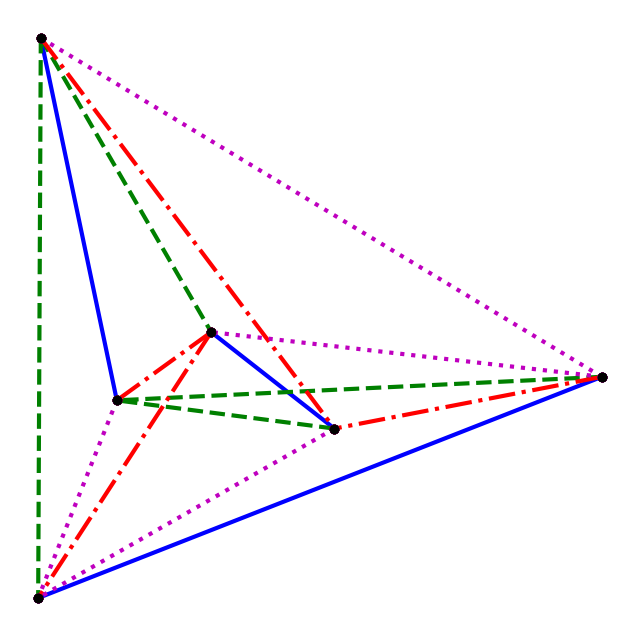

In [ ]:
components = [[3, 8, 9], [2, 4, 7, 10], [1, 5, 12, 13], [0, 6, 11, 14]]
plot_edges(components, data[78:84], "output3.svg")

In [ ]:
check_pointset(72,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[240, 32], [15, 7], [61, 102], [180, 75], [118, 164], [94, 249]],
 [[[3, 4, 5, 6], [0, 11, 12], [2, 7, 10, 13], [1, 8, 9, 14]],
  [[2, 4, 5, 7], [0, 11, 12], [1, 8, 10, 13], [3, 6, 9, 14]],
  [[3, 8, 9], [2, 4, 7, 10], [1, 5, 12, 13], [0, 6, 11, 14]],
  [[3, 4, 6, 9], [2, 8, 10], [0, 7, 11, 13], [1, 5, 12, 14]],
  [[3, 4, 6, 9], [2, 7, 11], [0, 8, 10, 12], [1, 5, 13, 14]],
  [[3, 8, 9], [2, 6, 10, 11], [4, 5, 7, 13], [0, 1, 12, 14]],
  [[3, 8, 9], [4, 6, 7, 11], [2, 5, 10, 13], [0, 1, 12, 14]],
  [[3, 4, 6, 9], [2, 7, 11], [1, 8, 10, 13], [0, 5, 12, 14]],
  [[3, 4, 5, 9], [1, 8, 12], [2, 7, 10, 13], [0, 6, 11, 14]],
  [[4, 8, 9, 10], [2, 7, 11], [0, 1, 12, 13], [3, 5, 6, 14]],
  [[3, 6, 8, 10], [2, 7, 11], [0, 1, 12, 13], [4, 5, 9, 14]],
  [[2, 8, 10], [4, 6, 7, 11], [0, 1, 12, 13], [3, 5, 9, 14]],
  [[2, 4, 7, 10], [3, 6, 11], [0, 5, 12, 13], [1, 8, 9, 14]],
  [[4, 8, 9, 10], [3, 6, 11], [2, 5, 7, 13], [0, 1, 12, 14]],
  [[2, 4, 5, 10], [1, 8, 12], [0, 7, 11, 13], [3, 6, 9, 14]],
  

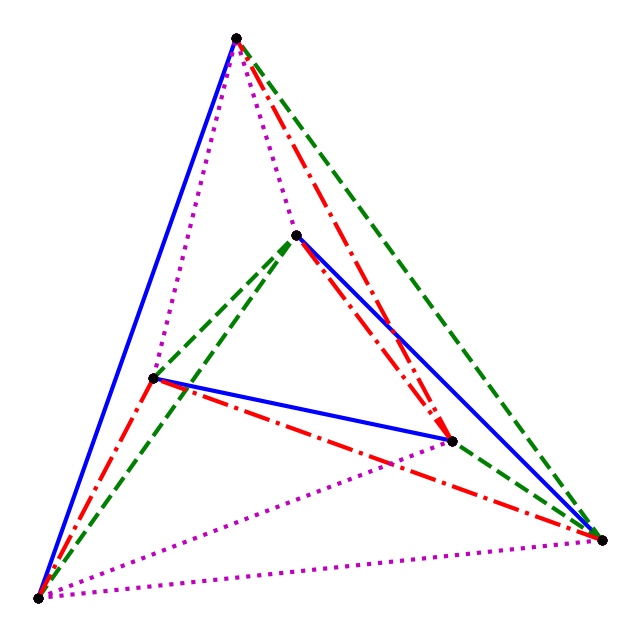

In [ ]:
components = [[3, 8, 9], [2, 4, 7, 10], [1, 5, 12, 13], [0, 6, 11, 14]]
plot_edges(components, data[72:78], "output4.svg")

In [ ]:
check_pointset(66,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[244, 5], [3, 72], [144, 167], [178, 137], [217, 134], [221, 251]],
 [[[4, 7, 9], [3, 6, 8, 10], [1, 5, 12, 13], [0, 2, 11, 14]],
  [[4, 7, 9], [2, 6, 10, 11], [3, 5, 8, 12], [0, 1, 13, 14]],
  [[4, 6, 10], [3, 7, 9, 11], [2, 5, 8, 12], [0, 1, 13, 14]],
  [[2, 8, 10], [3, 7, 9, 11], [0, 1, 12, 13], [4, 5, 6, 14]],
  [[4, 6, 10], [3, 7, 9, 11], [0, 5, 12, 13], [1, 2, 8, 14]],
  [[2, 8, 10], [4, 6, 7, 11], [0, 1, 12, 13], [3, 5, 9, 14]],
  [[2, 4, 5, 10], [1, 8, 12], [0, 7, 11, 13], [3, 6, 9, 14]],
  [[0, 2, 10, 11], [1, 8, 12], [4, 5, 7, 13], [3, 6, 9, 14]]])

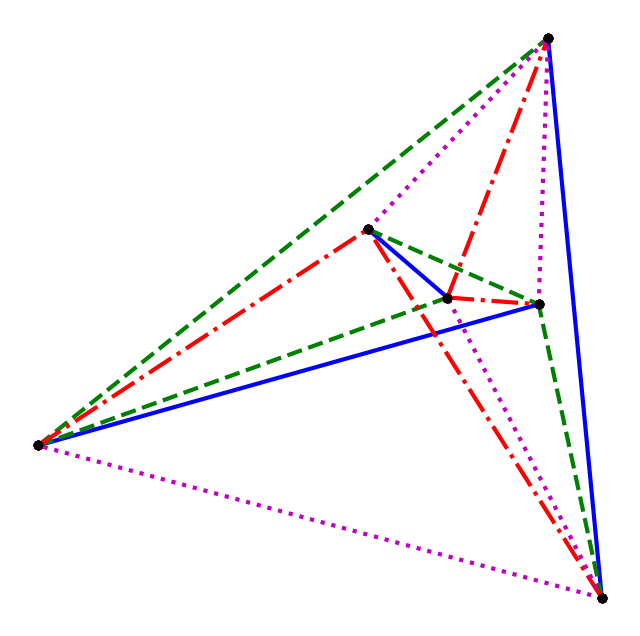

In [ ]:
components = [[4, 7, 9], [3, 6, 8, 10], [1, 5, 12, 13], [0, 2, 11, 14]]
plot_edges(components, data[66:72], "output5.svg")

In [ ]:
check_pointset(60,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[2, 238], [245, 218], [227, 130], [198, 120], [125, 147], [236, 27]], [])

In [ ]:
check_pointset(54,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[207, 211], [235, 16], [170, 66], [130, 25], [89, 197], [41, 230]], [])

In [ ]:
check_pointset(48,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[2, 227], [100, 243], [235, 209], [105, 202], [154, 163], [42, 13]],
 [[[3, 4, 6, 9], [2, 7, 11], [0, 8, 10, 12], [1, 5, 13, 14]],
  [[4, 8, 9, 10], [2, 7, 11], [0, 1, 12, 13], [3, 5, 6, 14]],
  [[4, 8, 9, 10], [3, 6, 11], [2, 5, 7, 13], [0, 1, 12, 14]]])

In [ ]:
vertices_data = data[48:54]
edges_data = generate_edges(vertices_data)

edges_data

[([2, 227], [100, 243]),
 ([2, 227], [235, 209]),
 ([2, 227], [105, 202]),
 ([2, 227], [154, 163]),
 ([2, 227], [42, 13]),
 ([100, 243], [235, 209]),
 ([100, 243], [105, 202]),
 ([100, 243], [154, 163]),
 ([100, 243], [42, 13]),
 ([235, 209], [105, 202]),
 ([235, 209], [154, 163]),
 ([235, 209], [42, 13]),
 ([105, 202], [154, 163]),
 ([105, 202], [42, 13]),
 ([154, 163], [42, 13])]

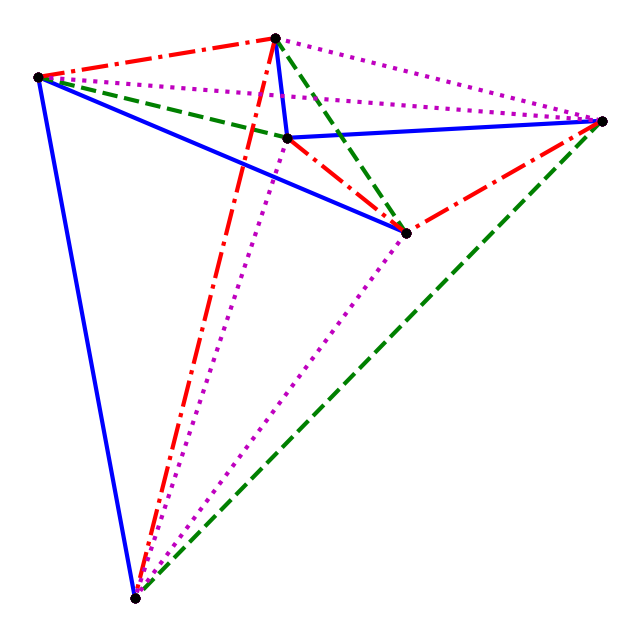

In [ ]:
components = [[3, 4, 6, 9], [2, 7, 11], [0, 8, 10, 12], [1, 5, 13, 14]]
plot_edges(components, data[48:54], "output6.svg")

In [ ]:
check_pointset(42,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[14, 115], [105, 238], [205, 220], [118, 142], [242, 19], [74, 31]], [])

In [ ]:
check_pointset(36,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[241, 99], [164, 29], [15, 85], [73, 108], [113, 162], [44, 227]], [])

In [ ]:
check_pointset(30,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[73, 201], [160, 173], [219, 83], [119, 94], [81, 135], [37, 55]], [])

In [ ]:
check_pointset(24,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[91, 10], [55, 7], [28, 249], [62, 189], [182, 108], [248, 120]], [])

In [ ]:
check_pointset(18,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[0, 172], [16, 198], [241, 244], [157, 140], [101, 110], [99, 12]], [])

In [ ]:
check_pointset(12,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[113, 247], [177, 236], [249, 57], [208, 8], [93, 161], [7, 145]], [])

In [ ]:
check_pointset(6,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[169, 32], [84, 4], [11, 37], [76, 255], [147, 205], [244, 198]], [])

In [ ]:
check_pointset(0,6)

checked 0 partitions
checked 30 partitions
checked 60 partitions
checked 90 partitions


([[230, 192], [248, 78], [148, 36], [54, 72], [30, 160], [126, 220]], [])

Our goal is to generalize this method, or exlpore a new one to help us find decompositons of bigger pointsets.